In [11]:
path = 'lab8/'

import pandas as pd
import re
import nltk
from nltk import CFG, BottomUpChartParser, BottomUpLeftCornerChartParser, LeftCornerChartParser
from nltk.metrics import jaccard_distance
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr
from IPython.display import display_html
import svgling
import contextlib

from nltk.parse.corenlp import CoreNLPDependencyParser

[nltk_data] Downloading package stopwords to /home/beny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Lab 8: Parsing

For the eighth practical of the subject, the goal is to try some non-probabilistic parsers, and optionally probabilistic parsers as well. The **mandatory** statement is:

1. Consider the following sentence:
`Lazy cats play with mice.`
2. Expand the grammar of the example related to non-probabilistic chart parsers in order to subsume this new sentence.
3. Perform the constituency parsing using a BottomUpChartParser, a BottomUpLeftCornerChartParser and a LeftCornerChartParser.
4. For each one of them, provide the resulting tree, the number of edges and the list of explored edges.
5. Which parser is the most efficient for parsing the sentence?
6. Which edges are filtered out by each parser and why?

The **optional** statement, which we've also accomplished, is:

1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.
2. Compute the Jaccard similarity of each pair using the dependency triples from CoreNLPDependencyParser.
3. Show the results. Do you think it could be relevant to use NEs to compute the similarity between two sentences? Justify the answer.

## Mandatory exercise: Non-probabilistic parsers

We add the words `"lazy"` (adjective, `Adj`), `"play"` (verb, `V`) and `"with"` (preposition, `PP`) in order to expand the grammar given so it satisfies the sentence `Lazy cats play with mice`. 

Reference: https://www.nltk.org/book/ch08.html

In [102]:
grammar = CFG.fromstring('''
  S   -> NP VP
  VP -> V | V PP NP
  NP  ->  NNS | JJ NNS
  NNS -> "cats" | "mice" 
  PP  -> "with"
  V   -> "play"
  JJ  -> "Lazy"
  ''')
sent = ['Lazy', 'cats', 'play', 'with', 'mice']

In [103]:
results = pd.DataFrame(columns = ['Parser', 'Edges', 'Trees'])
def parsers(grammar, sent, parser_func):
    parser = getattr(nltk, parser_func)(grammar, trace=1)
    parse = parser.parse(sent)
    trees = [t for t in parse]
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        parse = parser.chart_parse(sent)
    print('-'*80)
    print('Number of trees:', len(trees))
    print('Number of edges:', parse.num_edges())
    print('-'*80)

    [print(edge) for edge in parse.edges()]
    return parse.num_edges(), len(trees), trees[0] 

### BottomUpChartParser

|.  Lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'Lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|>       .       .       .       .       .| [0:0] JJ -> * 'Lazy'
|[-------]       .       .       .       .| [0:1] JJ -> 'Lazy' *
|>       .       .       .       .       .| [0:0] NP -> * JJ NNS
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       >       .       .       .       .| [1:1] NNS -> * 'cats'
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       >       .       .       .       .| [1:1] NP -> * NNS
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|.       >       .       .       .       .| [1:1] S  -> * NP VP
|.       [------->       .

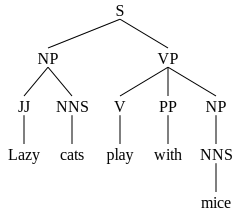

In [104]:
edges, trees, tree = parsers(grammar, sent, 'BottomUpChartParser')
results.loc[len(results)] = ['Bottom Up', edges, trees] 
svgling.draw_tree(tree)

### BottomUpLeftCornerChartParser

|.  Lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'Lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'Lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|.       [------->       .       .       .| [1:2] S  -> NP * VP
|.       .       [-------]       .       .| [2:3] V  -> 'play' *
|.       .       [-------]       .       .| [2:3] VP -> V *
|.       .       [------->       .       .| [2:3] VP -> V * PP NP
|[-----------------------]   

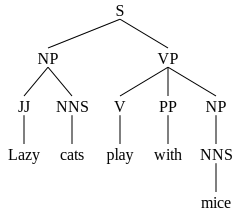

In [105]:
edges, trees, tree = parsers(grammar, sent, 'BottomUpLeftCornerChartParser')
results.loc[len(results)] = ['Bottom Up Left Corner', edges, trees] 
svgling.draw_tree(tree)

### LeftCornerChartParser

|.  Lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'Lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'Lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|.       [------->       .       .       .| [1:2] S  -> NP * VP
|.       .       [-------]       .       .| [2:3] V  -> 'play' *
|.       .       [-------]       .       .| [2:3] VP -> V *
|.       .       [------->       .       .| [2:3] VP -> V * PP NP
|[-----------------------]   

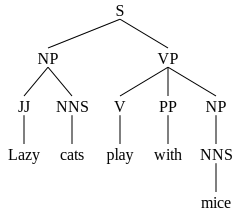

In [106]:
edges, trees, tree = parsers(grammar, sent, 'LeftCornerChartParser')
results.loc[len(results)] = ['Left Corner', edges, trees] 
svgling.draw_tree(tree)

### **Conclusions**


In [107]:
results

,Parser,Edges,Trees
0,Bottom Up,38,1
1,Bottom Up Left Corner,25,1
2,Left Corner,24,1


**Which parser is the most efficient for parsing the sentence?**

We have seen that all three parsers correctly parse the sentence. The main difference, in this case, is in the number of edges the parser needs to return the final tree. The number of edges basically means the efficiency of the parser in returning the tree, where less edges means more efficiency, i.e. less edges traversed to complete the parse.

We see in the summary table, that the the Bottom Up parser returns the worst results with 38 edges, while the Bottom Left Corner and the Left Corner return almost identical results, with the Left Corner beating the Bottom Up Left Corner by one edge.


**Which edges are filtered out by each parser and why?**

Comparing the Bottom Up, with the Bottom Up Left Corner, we see that the Bottom up has a few more edges. For example, it always has the `*` on the left first. These have been removed on the Bottom Up Left Corner.

- **Bottom-Up**: it takes the input string and tries to combine words to constituents and constituents to bigger constituents using the grammar rules from right to left. In doing so, any constituent that can be built are built; no matter whether they fit into the constituent that we are working on a the moment or not.

- **Left-Corner**: alternates steps of bottom-up processing with top-down predictions. It imposes top-down constraints that what follow in what the following input string can be. It starts with top-down prediction fixing the category that is to be recognized and then takes a bottom-up step and alternates between the both until it is subsumed.

For example, on the Bottom Up, the following appears:
```
[0:0] JJ -> * 'Lazy'
[0:0] NP -> * JJ NNS
[1:1] NNS -> * 'cats'
[1:1] NP -> * NNS
[1:1] S  -> * NP VP
[0:0] S  -> * NP VP
[2:2] V  -> * 'play'
[2:2] VP -> * V
[2:2] VP -> * V PP NP
[4:4] NP -> * NNS
[2:2] VP -> * V
[3:3] PP -> * 'with'
[4:4] NNS -> * 'mice'
```

Every edge starts with the `* constituent` and this is filtered on the Bottom Up Left Corner and Left Corner. Thanks to the left corner filtering.


Comparing Bottom Up Left Corner with Left Corner, we can see that the Left Corner does not have the edge `[4:5] S  -> NP * VP`, which the bottom up left corner does have.

## Optional exercise: Dependency parser

To use, we first need to download and run the CoreNLP server on `localhost:9000` by following the next few steps:

1. Download CoreNLP at https://stanfordnlp.github.io/CoreNLP/download.html
2. Unzip the files and run the following command in the that directory to start the server: `java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000`

`java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -preload tokenize,ssplit,pos,lemma,ner,parse,depparse -status_port 9000 -port 9000 -timeout 15000 & `



In [13]:
parser = CoreNLPDependencyParser(url='http://localhost:9000/')

In [14]:
def apply_jaccard_distance(sentence1, sentence2):
    if len(sentence1.union(sentence2)) == 0:
        return 0
    else:
        return 5*(1 - jaccard_distance(sentence1, sentence2))

In [15]:
def data_reader(function_preprocess):
    dt = pd.read_csv(path + 'STS.input.SMTeuroparl.txt', sep='\t', header = None)
    dt[2] = dt.apply(lambda row: function_preprocess(row[0]), axis = 1)
    dt[3] = dt.apply(lambda row: function_preprocess(row[1]), axis = 1)
    dt['gs'] = pd.read_csv(path + 'STS.gs.SMTeuroparl.txt', sep='\t', header = None)
    dt['jac'] = dt.apply(lambda row: apply_jaccard_distance(row[2], row[3]), axis = 1)
    return dt

In [20]:
stopw = set(nltk.corpus.stopwords.words('english')) # english stopwords


def apply_CoreNLDPependencyParser(sentence):
    parse, = parser.raw_parse(sentence)
    triples = []
    for governor, dep, dependent in parse.triples():
        if dep == 'punct' or governor[0].lower() in stopw:
            continue
        triples.append(( (governor[0].lower(), governor[1]), dep, (dependent[0].lower(), dependent[1])))
    return set(triples)

In [21]:
dt = data_reader(apply_CoreNLDPependencyParser)

In [24]:
styler = dt.head(3).style.set_table_attributes("style='display:inline'")
display_html(styler._repr_html_(), raw=True)

,0,1,2,3,gs,jac
0,The leaders have now been given a new chance and let us hope they seize it.,The leaders benefit aujourd' hui of a new luck and let's let them therefore seize it.,"{(('seize', 'VB'), 'nsubj', ('they', 'PRP')), (('given', 'VBN'), 'aux:pass', ('been', 'VBN')), (('let', 'VB'), 'ccomp', ('hope', 'VB')), (('leaders', 'NNS'), 'det', ('the', 'DT')), (('given', 'VBN'), 'aux', ('have', 'VBP')), (('hope', 'VB'), 'nsubj', ('us', 'PRP')), (('chance', 'NN'), 'amod', ('new', 'JJ')), (('seize', 'VB'), 'obj', ('it', 'PRP')), (('given', 'VBN'), 'advmod', ('now', 'RB')), (('given', 'VBN'), 'conj', ('let', 'VB')), (('chance', 'NN'), 'det', ('a', 'DT')), (('given', 'VBN'), 'nsubj:pass', ('leaders', 'NNS')), (('given', 'VBN'), 'obj', ('chance', 'NN')), (('let', 'VB'), 'cc', ('and', 'CC')), (('hope', 'VB'), 'ccomp', ('seize', 'VB'))}","{(('luck', 'NN'), 'case', ('of', 'IN')), (('let', 'VB'), 'nsubj', (""'s"", 'PRP')), (('seize', 'VB'), 'nsubj', ('them', 'PRP')), (('hui', 'NNP'), 'nmod', ('luck', 'NN')), (('seize', 'VB'), 'advmod', ('therefore', 'RB')), (('luck', 'NN'), 'det', ('a', 'DT')), (('leaders', 'NNS'), 'det', ('the', 'DT')), (('seize', 'VB'), 'obj', ('it', 'PRP')), (('luck', 'NN'), 'amod', ('new', 'JJ')), (('benefit', 'VBP'), 'conj', ('let', 'VB')), (('let', 'VB'), 'ccomp', ('seize', 'VB')), (('benefit', 'VBP'), 'nsubj', ('leaders', 'NNS')), (('let', 'VB'), 'cc', ('and', 'CC')), (('let', 'VB'), 'ccomp', ('let', 'VB')), (('hui', 'NNP'), 'compound', ('aujourd', 'NN')), (('benefit', 'VBP'), 'obj', ('hui', 'NNP'))}",4.500000,0.535714
1,Amendment No 7 proposes certain changes in the references to paragraphs.,Amendment No 7 is proposing certain changes in the references to paragraphs.,"{(('proposes', 'VBZ'), 'obj', ('changes', 'NNS')), (('changes', 'NNS'), 'amod', ('certain', 'JJ')), (('7', 'NNP'), 'compound', ('amendment', 'NNP')), (('references', 'NNS'), 'case', ('in', 'IN')), (('references', 'NNS'), 'det', ('the', 'DT')), (('7', 'NNP'), 'compound', ('no', 'NNP')), (('references', 'NNS'), 'nmod', ('paragraphs', 'NNS')), (('paragraphs', 'NNS'), 'case', ('to', 'IN')), (('proposes', 'VBZ'), 'nsubj', ('7', 'NNP')), (('changes', 'NNS'), 'nmod', ('references', 'NNS'))}","{(('proposing', 'VBG'), 'aux', ('is', 'VBZ')), (('changes', 'NNS'), 'amod', ('certain', 'JJ')), (('7', 'NNP'), 'compound', ('amendment', 'NNP')), (('references', 'NNS'), 'case', ('in', 'IN')), (('references', 'NNS'), 'det', ('the', 'DT')), (('7', 'NNP'), 'compound', ('no', 'NNP')), (('references', 'NNS'), 'nmod', ('paragraphs', 'NNS')), (('paragraphs', 'NNS'), 'case', ('to', 'IN')), (('proposing', 'VBG'), 'nsubj', ('7', 'NNP')), (('changes', 'NNS'), 'nmod', ('references', 'NNS')), (('proposing', 'VBG'), 'obj', ('changes', 'NNS'))}",5.000000,3.076923
2,Let me remind you that our allies include fervent supporters of this tax.,"I would like to remind you that among our allies, there are strong of this tax.","{(('let', 'VB'), 'ccomp', ('remind', 'VB')), (('include', 'VBP'), 'obj', ('supporters', 'NNS')), (('tax', 'NN'), 'case', ('of', 'IN')), (('tax', 'NN'), 'det', ('this', 'DT')), (('include', 'VBP'), 'nsubj', ('allies', 'NNS')), (('remind', 'VB'), 'nsubj', ('me', 'PRP')), (('supporters', 'NNS'), 'nmod', ('tax', 'NN')), (('allies', 'NNS'), 'nmod:poss', ('our', 'PRP$')), (('remind', 'VB'), 'obj', ('you', 'PRP')), (('include', 'VBP'), 'mark', ('that', 'IN')), (('supporters', 'NNS'), 'amod', ('fervent', 'JJ')), (('remind', 'VB'), 'ccomp', ('include', 'VBP'))}","{(('remind', 'VB'), 'ccomp', ('are', 'VBP')), (('tax', 'NN'), 'case', ('of', 'IN')), (('like', 'VB'), 'nsubj', ('i', 'PRP')), (('tax', 'NN'), 'det', ('this', 'DT')), (('allies', 'NNS'), 'nmod:poss', ('our', 'PRP$')), (('remind', 'VB'), 'obj', ('you', 'PRP')), (('remind', 'VB'), 'mark', ('to', 'TO')), (('allies', 'NNS'), 'case', ('among', 'IN')), (('like', 'VB'), 'aux', ('would', 'MD')), (('strong', 'JJ'), 'obl', ('tax', 'NN')), (('like', 'VB'), 'xcomp', ('remind', 'VB'))}",4.250000,1.052632


In [23]:
pearsonr(dt['gs'], dt['jac'])[0]

0.3280739664753573

**Is it relevant to compute the triples?**

Comparing the triples like we are doing now is not relevant for the STS task. CoreNLP takes in a raw test and runs a series of steps (tokenize, split, POS, lemma, ner, deparse) to obtain a final set of annotations. Using the POS tags of these sets might be better than using the previously tested ones. However, using the entire set of triples to compare the STS results in worse results than just comparing the tokens. Hence, we might use it to extract the POS and perhaps it could improve the default NLTK results.